In [1]:
import pandas as pd
import numpy as np

In [2]:
combined_df=pd.read_csv("C:\\Users\\Admin\\OneDrive\\Desktop\\MAJOR_PROJECT\\NEW_FILES\\VPN-NONVPN.csv")

In [3]:
row_count, column_count = combined_df.shape
print("Row count:", row_count)
print("Column count:", column_count)

Row count: 623290
Column count: 74


In [4]:
label_distribution = combined_df['Label'].value_counts()
print("\nLabel Distribution:")
print(label_distribution)


Label Distribution:
VOIP             533427
EMAIL             56492
CHAT              21364
P2P                6769
FILE TRANSFER      2901
STREAMING          2337
Name: Label, dtype: int64


In [5]:
class_distribution = combined_df['Class'].value_counts()
print("\nClass Distribution:")
print(class_distribution)


Class Distribution:
VPN        423385
NON VPN    199905
Name: Class, dtype: int64


In [6]:
# Number of entries in each column
entries_per_column = combined_df.count()
print("\nNumber of entries in each column:")
print(entries_per_column)


Number of entries in each column:
frame.len                         623290
ip.proto                          586901
tcp.srcport                           61
tcp.dstport                           61
udp.srcport                       592771
                                   ...  
tcp.analysis.zero_window               0
tcp.analysis.zero_window_probe         0
frame.cap_len.1                   623290
Label                             623290
Class                             623290
Length: 74, dtype: int64


In [7]:
# Missing values in each column
missing_values_per_column = combined_df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values_per_column)


Missing values in each column:
frame.len                              0
ip.proto                           36389
tcp.srcport                       623229
tcp.dstport                       623229
udp.srcport                        30519
                                   ...  
tcp.analysis.zero_window          623290
tcp.analysis.zero_window_probe    623290
frame.cap_len.1                        0
Label                                  0
Class                                  0
Length: 74, dtype: int64


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D,Dropout
#from keras.preprocessing.text import Tokenizer
#from keras.utils import to_categorical

In [9]:
# Assuming combined_df is your DataFrame containing the data
vpn_packets = combined_df[combined_df['Class'] == 'VPN'].head(10000)


remaining_packets = combined_df[(combined_df['Class'] != 'VPN')].head(10000)
# Concatenate the first 2000 VOIP packets, 2000 P2P packets, and the remaining packets
final_dataset = pd.concat([vpn_packets, remaining_packets], ignore_index=True)
print(final_dataset.shape)

(20000, 74)


In [10]:
# Define a list of unwanted column names
#unwanted_columns = ['frame.len', 'tcp.seq','tcp.flags.syn','tcp.flags.ack','tcp.flags.push', 'tcp.flags.reset',\
                   #'data.len','udp.length.bad','udp.length.bad_zero']  # Add all unwanted column names here

    
unwanted_columns = ['frame.len','tcp.flags.syn','tcp.flags.ack','tcp.flags.push', 'tcp.flags.reset',\
                   'data.len','Label']  # Add all unwanted column names here
# Remove unwanted columns from the DataFrame
filtered_df = final_dataset.drop(columns=unwanted_columns)

# Display the filtered DataFrame
print(filtered_df)

       ip.proto  tcp.srcport  tcp.dstport  udp.srcport  udp.dstport  tcp.seq  \
0          17.0          NaN          NaN      15685.0      40002.0      NaN   
1          17.0          NaN          NaN      40002.0      15685.0      NaN   
2          17.0          NaN          NaN      15685.0      40027.0      NaN   
3          17.0          NaN          NaN      40027.0      15685.0      NaN   
4          17.0          NaN          NaN      23581.0         53.0      NaN   
...         ...          ...          ...          ...          ...      ...   
19995      17.0          NaN          NaN      33306.0      19305.0      NaN   
19996      17.0          NaN          NaN      19305.0      33306.0      NaN   
19997      17.0          NaN          NaN      33306.0      19305.0      NaN   
19998      17.0          NaN          NaN      19305.0      33306.0      NaN   
19999      17.0          NaN          NaN      19305.0      33306.0      NaN   

       frame.time_epoch  tcp.stream  ip

In [11]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Map the 'Class' column using the same label encoding as 'Label'
filtered_df['Class'] = label_encoder.fit_transform(filtered_df['Class'])

# Display the encoded labels
print("Encoded Class:")
print(filtered_df['Class'].value_counts())

Encoded Class:
1    10000
0    10000
Name: Class, dtype: int64


In [12]:
# Mapping original labels to encoded values for both 'Class' and 'Label'
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:")
print(class_mapping)

Class Mapping:
{'NON VPN': 0, 'VPN': 1}


In [13]:
X = filtered_df.drop(columns=['Class'])
y = filtered_df['Class']

In [14]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
num_classes = len(encoder.classes_)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(16000, 66)
(16000,)


In [16]:
from sklearn.impute import SimpleImputer

# Impute missing values in the features
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test= imputer.transform(X_test)

In [17]:
x_training_data = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
print(x_training_data.shape)

(16000, 30, 1)


In [18]:
import time
import psutil
import os

# CNN - RNN COMBINED MODEL

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Define input shape based on your data
input_shape = (x_training_data.shape[1], 1)  # Shape of your input data assuming it's sequential

# Define the number of classes for the output
num_classes = 2  # Assuming you have 6 classes for the output

# get the start time
#start_wall_time = time.time()
#start_cpu_time = time.process_time()

# Create the combined RNN-CNN model
model = Sequential([
    # CNN layers
    Conv1D(32, 3, activation='relu', input_shape=input_shape),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    #Flatten(),

    # RNN layers
    SimpleRNN(units=64, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(units=64),
    Dropout(0.2),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=24, validation_data=(X_test, y_test),callbacks=[early_stopping])

# get the end time
#end_wall_time = time.time()
#end_cpu_time = time.process_time()

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 6, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,978 (89.76 KB)

 Trainable params: 22,978 (89.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8621 - loss: 0.3192 - val_accuracy: 0.9540 - val_loss: 0.1258
Epoch 2/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9350 - loss: 0.1760 - val_accuracy: 0.9610 - val_loss: 0.0925
Epoch 3/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9473 - loss: 0.1365 - val_accuracy: 0.9647 - val_loss: 0.0804
Epoch 4/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9469 - loss: 0.1282 - val_accuracy: 0.9542 - val_loss: 0.0942
Epoch 5/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9569 - loss: 0.1118 - val_accuracy: 0.9680 - val_loss: 0.0844


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute predictions
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Compute predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9665 - loss: 0.0770
Test Loss: 0.08057184517383575
Test Accuracy: 0.9647499918937683
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1981
           1       0.98      0.95      0.96      2019

    accuracy                           0.96      4000
   macro avg       0.97      0.96      0.96      4000
weighted avg       0.97      0.96      0.96      4000



In [27]:
conf_matrix

array([[1944,   37],
       [ 104, 1915]], dtype=int64)

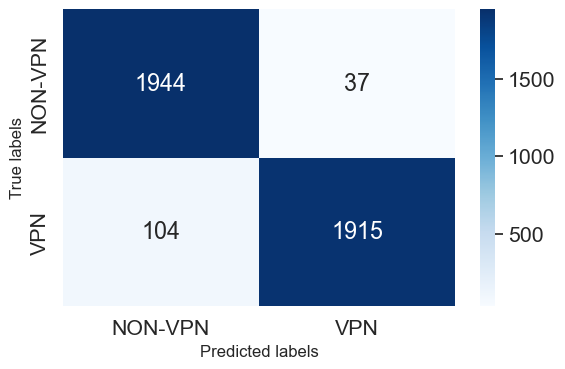

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define the labels for your classes
labels =['NON-VPN', 'VPN']

# Plot confusion matrix
plt.figure(figsize=(6, 4))  # Increase the size of the plot
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted labels', fontsize=12)  # Increase fontsize and adjust label position
plt.ylabel('True labels', fontsize=12)  # Increase fontsize and adjust label position
#plt.title('Confusion Matrix')

# Adjust layout to ensure all labels are fully visible
plt.tight_layout()

# Save the plot as an image file
plt.savefig('cm_NON-VPN-vs-VPN-COMBINED.png')

# Show the plot
plt.show()

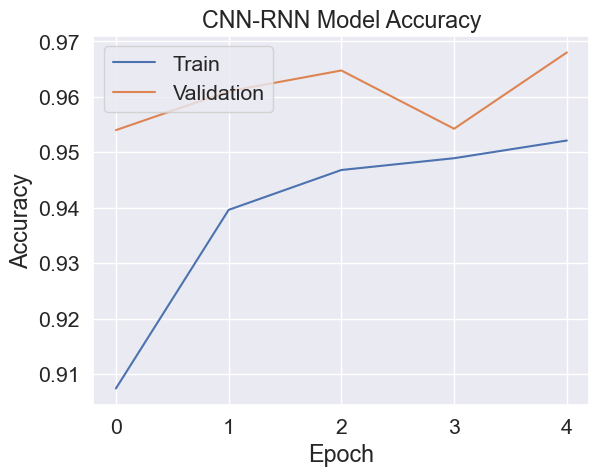

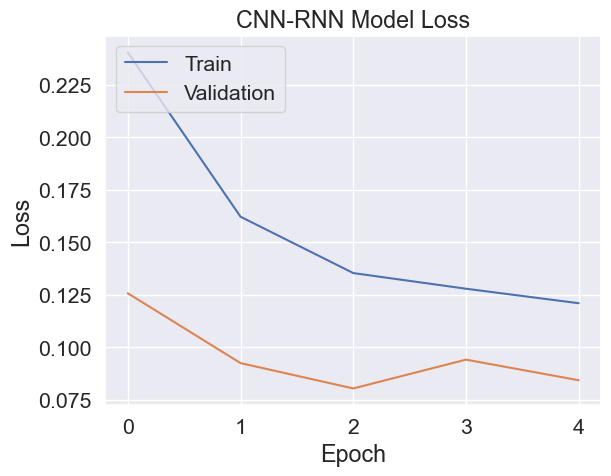

In [31]:
#Performance Metrics for RNN and CNN combined
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

# Train the model and capture the training history
#history = model.fit(X_train, y_train, epochs=3, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN-RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN-RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()





# RNN

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define input shape based on your data
input_shape = (x_training_data.shape[1], 1)  # Shape of your input data

# Define the number of classes for the output
num_classes = 2  # Assuming you have 6 classes for the output

# get the start time
start_wall_time = time.time()
start_cpu_time = time.process_time()

# Create the RNN model
rnn_model = Sequential([
    SimpleRNN(units=64, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    SimpleRNN(units=64, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(units=64),
    Dropout(0.2),
    Dense(units=num_classes, activation='softmax')
])

# Compile the model
rnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print the model summary
rnn_model.summary()

# Train the model with early stopping
history = rnn_model.fit(X_train, y_train, epochs=5, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping])

# get the end time
end_wall_time = time.time()
end_cpu_time = time.process_time()

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 30, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 30, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,866 (81.51 KB)

 Trainable params: 20,866 (81.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9757 - loss: 0.0910 - val_accuracy: 0.9850 - val_loss: 0.0580
Epoch 2/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9854 - loss: 0.0635 - val_accuracy: 0.9850 - val_loss: 0.0590
Epoch 3/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9857 - loss: 0.0597 - val_accuracy: 0.9865 - val_loss: 0.0595
Epoch 4/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9871 - loss: 0.0565 - val_accuracy: 0.9870 - val_loss: 0.0542
Epoch 5/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9878 - loss: 0.0502 - val_accuracy: 0.9868 - val_loss: 0.0549


In [33]:
# Evaluate the model on test data
loss, accuracy = rnn_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict labels for test data
y_pred = rnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9870 - loss: 0.0579
Test Loss: 0.054312653839588165
Test Accuracy: 0.9869999885559082
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1981
           1       0.98      0.99      0.99      2019

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



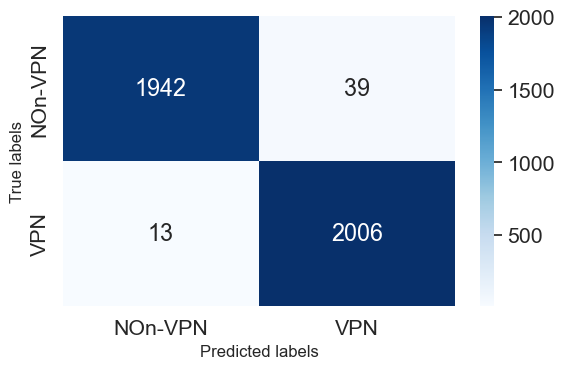

In [34]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Define the labels for your classes
labels =['NOn-VPN', 'VPN']

# Plot confusion matrix
plt.figure(figsize=(6, 4))  # Increase the size of the plot
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted labels', fontsize=12)  # Increase fontsize and adjust label position
plt.ylabel('True labels', fontsize=12)  # Increase fontsize and adjust label position
#plt.title('Confusion Matrix')

# Adjust layout to ensure all labels are fully visible
plt.tight_layout()

# Save the plot as an image file
plt.savefig('cm_VPN_vs_Non-VPN-RNN.png')

# Show the plot
plt.show()

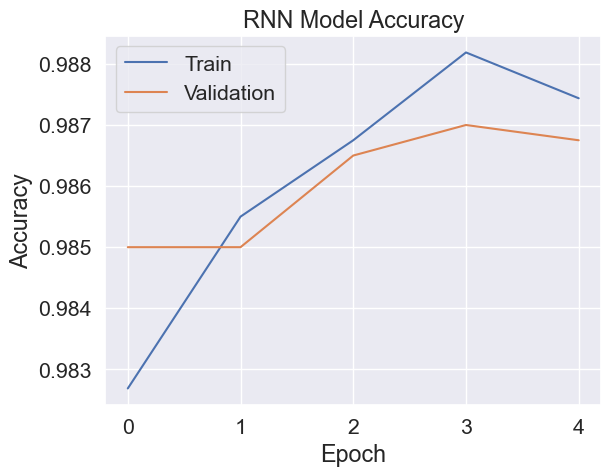

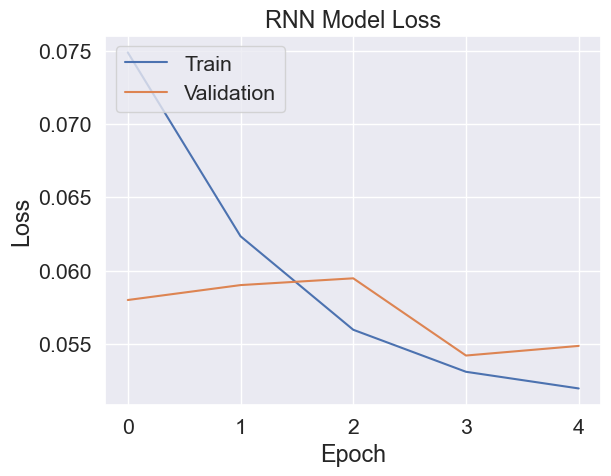

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Train the model with early stopping
#history = rnn_model.fit(X_train, y_train, epochs=5, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



# RBF NETWORK

In [36]:
import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [37]:
# get the start time
start_wall_time = time.time()
start_cpu_time = time.process_time()


# Define an RBF network pipeline
rbf_network = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=10),  # Adjust the number of clusters as needed
    SVC(kernel='rbf')
)

# Train the RBF network
rbf_network.fit(X_train, y_train)


# Make predictions on the testing data
y_pred = rbf_network.predict(X_test)

# get the end time
end_wall_time = time.time()
end_cpu_time = time.process_time()

C:\ProgramData\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [38]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Evaluate the model
from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred))




Accuracy: 0.98825
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1981
           1       0.98      1.00      0.99      2019

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



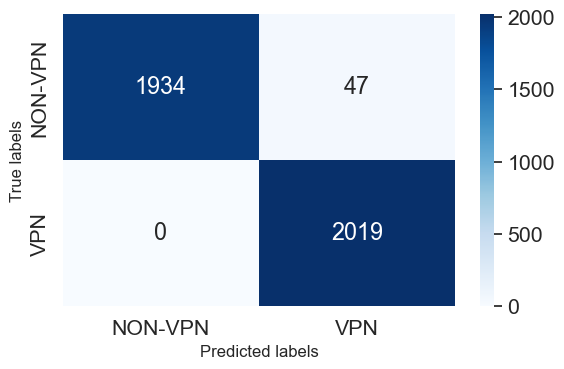

In [39]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Define the labels for your classes
labels =['NON-VPN', 'VPN']

# Plot confusion matrix
plt.figure(figsize=(6, 4))  # Increase the size of the plot
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted labels', fontsize=12)  # Increase fontsize and adjust label position
plt.ylabel('True labels', fontsize=12)  # Increase fontsize and adjust label position
#plt.title('Confusion Matrix')

# Adjust layout to ensure all labels are fully visible
plt.tight_layout()

# Save the plot as an image file
plt.savefig('cm_VPN_vs_Non-VPN-RBF.png')

# Show the plot
plt.show()

## COMPARISON OF PERFORMANCE OF ALL THE THREE MODELS

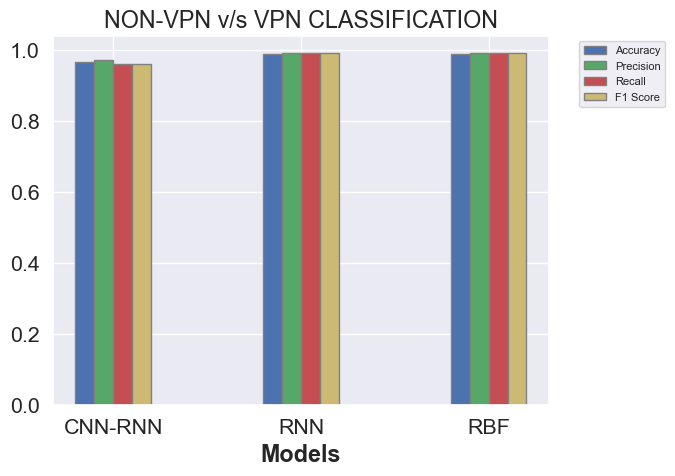

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Define the models and their metrics
models = ['CNN-RNN', 'RNN', 'RBF']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
accuracy = [.9647,.9869,.9882]
precision = [0.97, 0.99, 0.99]
recall = [0.96, 0.99, 0.99]
f1_score = [0.96, 0.99, 0.99]

# Set the width of the bars
bar_width = 0.1

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar graph
plt.bar(r1, accuracy, color='b', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, precision, color='g', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r3, recall, color='r', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r4, f1_score, color='y', width=bar_width, edgecolor='grey', label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width * 1.5 for r in range(len(models))], models)

#Add a legend with reduced font size and placed outside the graph
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.title('NON-VPN v/s VPN CLASSIFICATION')
plt.show()
